In [2]:
import numpy as np
import json
import matplotlib.pyplot as plt
import covid_funs
import importlib
import subprocess
import sys
import shlex

In [3]:
#from https://www.endpoint.com/blog/2015/01/28/getting-realtime-output-using-python
def run_command(command):
    process = subprocess.Popen(shlex.split(command), stdout=subprocess.PIPE, stderr = subprocess.STDOUT, text = False)
    outlist = []
    while True:
        output = process.stdout.readline()
        outlist += [output]
        if output.decode("utf-8") == '' and process.poll() is not None:
            break
        if output:
            if '\r' in output.decode("utf-8"):
                
                sys.stdout.write('\r' + output.decode("utf-8").strip())
            else:
                sys.stdout.write(output.decode("utf-8"))
    rc = process.poll()
    return rc,outlist

<module 'covid_funs' from '/Users/m197894/Documents/COVID_Model/disease_net/covid_funs.py'>

We can generate a simulated outbreak using the SIR model. We also give sampling bias and capacity. If capacity is given as a list, samples will be later generated for each capacity in the list. Capacity can also be given as a list (implying max capacities) and a function (which should take values from 0 to 1) for time-varying capacty. For this, pass the function as a keyword argument capacityfun to gen_jsons.

In [41]:
Bias = 1 #Bias = 1 means no bias. Higher puts bias towards testing symptomatic individuals.
capacities = [100,300,900,2700,8100]

def SIR_model(t,X,params):
    s,i,r= X
    beta,recrate = params
    if callable(beta):
        dsdt = -(beta(s,i,r,t))*s*i
    else:
        dsdt = -beta*s*i
    didt = -dsdt - recrate*i
    drdt = recrate*i
    return [dsdt,didt,drdt]

timescale = 15 #1/gamma


init_inf = 0.01

s0 = (1-init_inf)
i0 = init_inf
r0 = 0

R0 = 2.2

end_time = 100

dynamics = covid_funs.gen_jsons(end_time,[s0,i0,r0],SIR_model,1,-1,[0,2],[R0/timescale,1/timescale],Bias,capacities)

Note that we don't have to generate dynamics using an ODE. We could generate dynamics using a stochastic process, or simply assert a course of epidemic.

In [5]:
dynamics.keys()

dict_keys(['TimePoints', 'Symptomatic', 'Asymptomatic', 'NonInfected'])

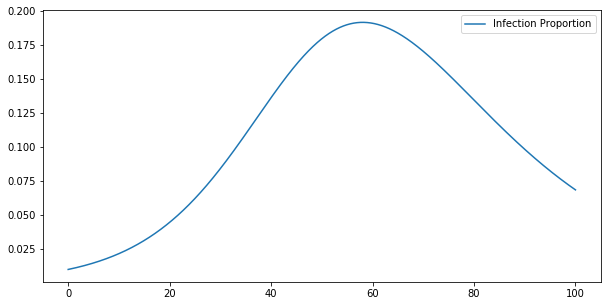

In [43]:
total_infected = np.array(dynamics['Symptomatic']) + np.array(dynamics['Asymptomatic'])

fig,ax = plt.subplots(figsize = (10,5))
ax.plot(dynamics["TimePoints"],total_infected, label = "Infection Proportion")

ax.legend()

We use a .go executible to generate simulated sampling.

In [84]:
%%time
svfl = "json_io/testresults.json"
dynamicsfl = "json_io/dynamics.json"
biasfl = "json_io/bias.json"
capfl = "json_io/capacity.json"
num_trials = 10
falsePos = 0.1
falseNeg = 0.1
smth = 5
peak_tol = 3

base_command = "./disease_confidence"
opts = ["-Dynamics="+dynamicsfl]
opts +=["-TestingBias="+biasfl]
opts +=["-TestingCapacities="+capfl]
opts +=["-Trials="+str(num_trials)]
opts +=["-SaveFile="+svfl]
opts +=["-FalsePositive="+str(falsePos)]
opts +=["-FalseNegative="+str(falseNeg)]
opts +=["-Smoothing="+str(smth)]
opts +=["-PeakTol="+str(peak_tol)]


full_command = base_command + " " + " ".join(opts)
so = run_command(full_command)

with open(svfl) as fl:
    results = json.load(fl)

CPU times: user 54 ms, sys: 18.5 ms, total: 72.6 ms
Wall time: 1min 5s


In [85]:
results.keys()

dict_keys(['Peaks', 'SumSqDistance', 'Performance', 'SimulatedData'])

In [176]:
pos_prop = {}
for ky in results["SimulatedData"]:
    smps = []
    times = []
    for sample in results["SimulatedData"][ky]:
        smps += [np.array(sample["DailyPositive"])/np.array(sample["DailyTotal"])]
        times += [np.array(sample["DayTimes"])]
    pos_prop[ky] = (smps,times)

In [56]:
pos_prop.keys()

dict_keys(['100', '2700', '300', '8100', '900'])

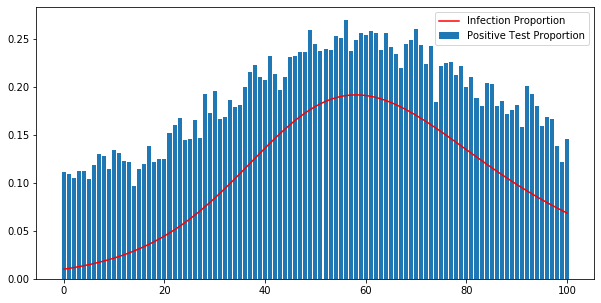

In [178]:

fig,ax = plt.subplots(figsize = (10,5))
ax.plot(dynamics["TimePoints"],total_infected, label = "Infection Proportion", color = 'red')
ax.bar(pos_prop["900"][1][0],pos_prop["900"][0][0], label = "Positive Test Proportion")

ax.legend()

<module 'covid_funs' from '/Users/m197894/Documents/COVID_Model/disease_net/covid_funs.py'>

In [179]:
samptrend = covid_funs.find_trend(pos_prop["900"][0][0],pos_prop["900"][1][0],[20,30])
realtrend = covid_funs.find_trend(total_infected,dynamics["TimePoints"],[20,30])
(samptrend,realtrend)

(0.0038704621314097926, 0.003955423361253156)

In [180]:
t1 = np.argwhere(20<=np.array(dynamics["TimePoints"]))[0,0]
t2 = np.argwhere(30<=np.array(dynamics["TimePoints"]))[0,0]

In [181]:
t1,t2

(2000, 3000)

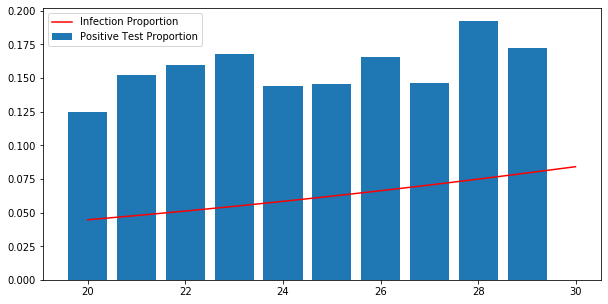

In [182]:
fig,ax = plt.subplots(figsize = (10,5))
ax.bar(pos_prop["900"][1][0][20:30],pos_prop["900"][0][0][20:30], label = "Positive Test Proportion")
ax.plot(dynamics["TimePoints"][t1:t2],total_infected[t1:t2], label = "Infection Proportion", color = 'red')
ax.legend()

In [183]:
real_trend,realwindows = covid_funs.test_all_windows(total_infected,dynamics["TimePoints"],5)
samp_trend,sampwindows = covid_funs.test_all_windows(pos_prop["900"][0][0],pos_prop["900"][1][0],5)

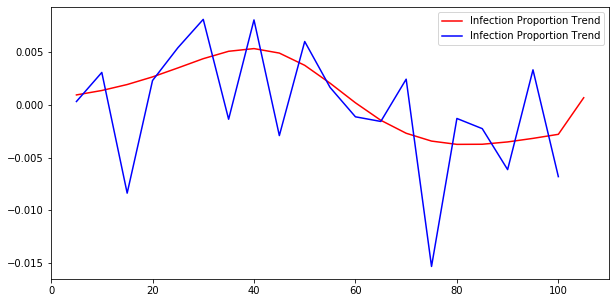

In [184]:
fig,ax = plt.subplots(figsize = (10,5))
ax.plot(realwindows,real_trend, label = "Infection Proportion Trend", color = 'red')
ax.plot(sampwindows,samp_trend, label = "Infection Proportion Trend", color = 'blue')
ax.legend()

In [194]:
importlib.reload(covid_funs)

<module 'covid_funs' from '/Users/m197894/Documents/COVID_Model/disease_net/covid_funs.py'>

In [192]:
covid_funs.trendError(real_trend,samp_trend)

(array([3.91987915e-07, 2.93634221e-06, 1.06312983e-04, 1.17758337e-07,
        3.67997338e-06, 1.39429982e-05, 4.16157278e-05, 7.41204991e-06,
        6.13524150e-05, 5.11260473e-06, 1.60653723e-07, 1.76915909e-06,
        1.21913734e-08, 2.63550035e-05, 1.41672055e-04, 6.04527090e-06,
        2.19554315e-06, 6.90929004e-06, 4.23699038e-05, 1.61413746e-05]),
 0.004932064912947633,
 0.7)

In [196]:
five_day_conf = {}
for ky in pos_prop.keys():
    five_day_conf[ky] = covid_funs.trendConfidence(pos_prop[ky][0],pos_prop[ky][1],total_infected,dynamics["TimePoints"],5)



In [197]:
five_day_conf

{'100': 0.5549999999999999,
 '2700': 0.805,
 '300': 0.63,
 '8100': 0.8850000000000001,
 '900': 0.74}

The go executible tries to find peaks in the dynamics. We can asses the precision and recall of this.

In [72]:
recall = {}
for ky,val in results["Performance"].items():
    recall[ky] = sum([pk["Found"] for dyn in val for  pk in dyn["Recalls"]])/sum([len(v["Recalls"]) for v in val])
    
precision = {}
for ky,val in results["Performance"].items():
    precision[ky] = sum([pk["Real"] for dyn in val for  pk in dyn["Precisions"]])/sum([len(v["Precisions"]) for v in val])
    
mean_sq_error = {}
for ky,val in results["Performance"].items():
    mean_sq_error[ky] =[(sum([(pk["SqDist"])**2 for pk in dyn["Precisions"]])/len(dyn["Precisions"]))**(1/2) for dyn in val]

In [73]:
recall

{'100': 0.8, '2700': 0.9, '300': 0.8, '8100': 1.0, '900': 0.9}

In [74]:
precision

{'100': 0.08108108108108109,
 '2700': 0.22388059701492538,
 '300': 0.09142857142857143,
 '8100': 0.5526315789473685,
 '900': 0.13385826771653545}

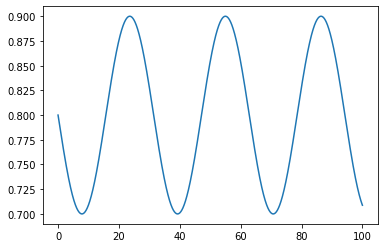

In [205]:
t = np.arange(0,100,0.01)
plt.plot(t,1-(0.1*np.sin(t/5) + 0.2))